### 4.1 import data

In [54]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [55]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [56]:
sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520331.00 MB
Decreased by 73.4%


In [59]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

### 4.2 LN model and 5 fold validation


In [60]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

#### 4.2 - 1 LN model


In [61]:
from sklearn.linear_model import LinearRegression

In [62]:
model = LinearRegression(normalize=True)

In [87]:
model = model.fit(train_X, train_y)

intercept vs coef

In [64]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.3416418945),
 ('v_8', 700675.5609398854),
 ('v_9', 170630.27723221667),
 ('v_7', 32322.66193202804),
 ('v_12', 20473.67079698077),
 ('v_3', 17868.079541505016),
 ('v_11', 11474.938996726354),
 ('v_13', 11261.764560017615),
 ('v_10', 2683.9200905879115),
 ('gearbox', 881.8225039248113),
 ('fuelType', 363.90425072154164),
 ('bodyType', 189.60271012072454),
 ('city', 44.949751205227734),
 ('power', 28.553901616752686),
 ('brand_price_median', 0.5103728134078654),
 ('brand_price_std', 0.4503634709262741),
 ('brand_amount', 0.14881120395065303),
 ('brand_price_max', 0.0031910186703129196),
 ('SaleID', 5.3559899198614894e-05),
 ('train', -1.862645149230957e-08),
 ('offerType', -2.3477477952837944e-06),
 ('seller', -3.5854754969477654e-06),
 ('brand_price_sum', -2.175006868187577e-05),
 ('name', -0.00029800127131090565),
 ('used_time', -0.0025158943328526563),
 ('brand_price_average', -0.4049048451010962),
 ('brand_price_min', -2.2467753486894555),
 ('power_bin', -34.42064411

In [65]:
from matplotlib import pyplot as plt

In [81]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

The predicted price is obvious different from true price


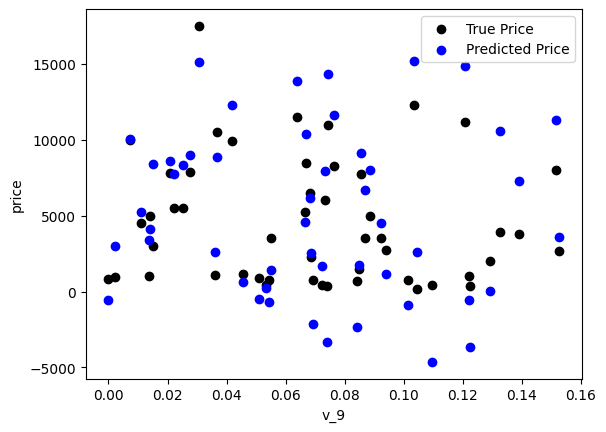

In [90]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


<Axes: xlabel='price', ylabel='Density'>

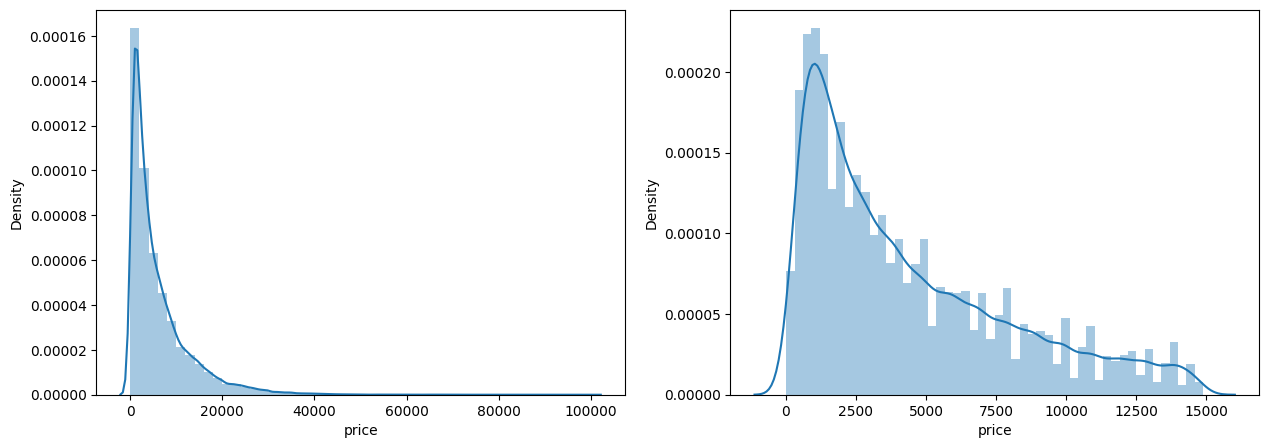

In [41]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

In [75]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


<Axes: xlabel='price', ylabel='Density'>

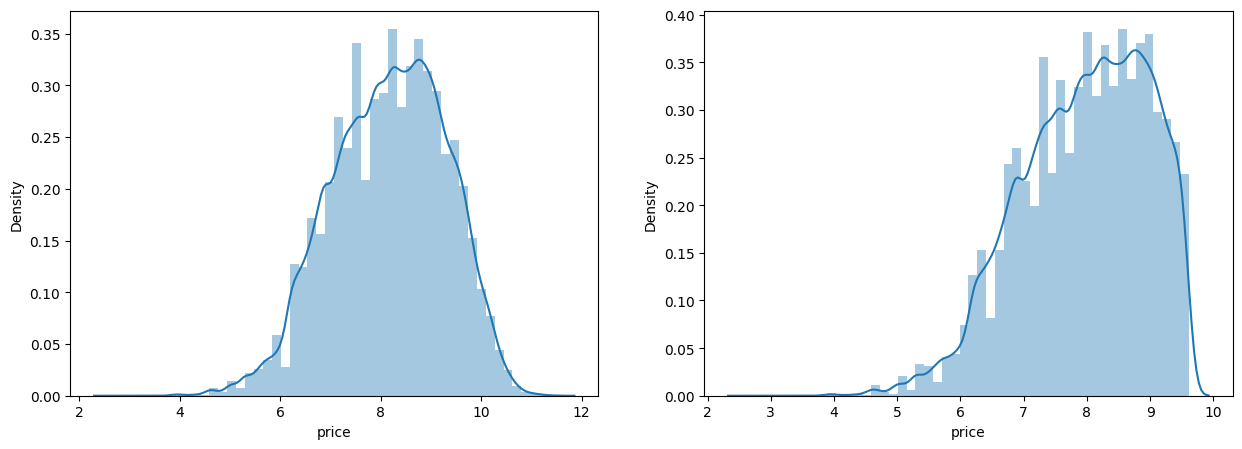

In [77]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [78]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750748443072172


[('v_9', 8.05241040881933),
 ('v_5', 5.764240780390856),
 ('v_12', 1.6182060982409956),
 ('v_1', 1.4798310645431054),
 ('v_11', 1.1669004173601452),
 ('v_13', 0.9404706327191817),
 ('v_7', 0.7137281645192867),
 ('v_3', 0.6837863827343363),
 ('v_0', 0.008500505209741039),
 ('power_bin', 0.008497968353527747),
 ('gearbox', 0.007922378343287092),
 ('fuelType', 0.006684768936309971),
 ('bodyType', 0.004523520651791064),
 ('power', 0.0007161895389361288),
 ('brand_price_min', 3.334354528988832e-05),
 ('brand_amount', 2.8978802894925613e-06),
 ('brand_price_median', 1.2571187771038937e-06),
 ('brand_price_std', 6.659170007177179e-07),
 ('brand_price_max', 6.194957302458889e-07),
 ('brand_price_average', 5.99934870669234e-07),
 ('SaleID', 2.1194159119232343e-08),
 ('train', -1.5916157281026244e-12),
 ('seller', -1.4781065260649484e-11),
 ('offerType', -7.739231477899011e-11),
 ('brand_price_sum', -1.5126514245684398e-10),
 ('name', -7.01551119583361e-08),
 ('used_time', -4.122477016271524e-06

The predicted price seems normal after np.log transforming


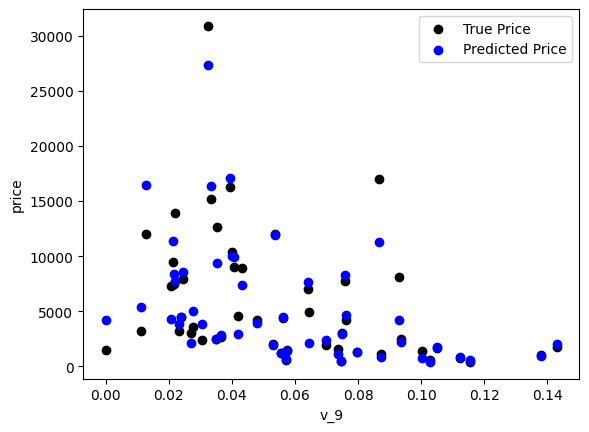

In [17]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

#### 4.2 - 2 5 fold validation

In [93]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [94]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [95]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s finished


Error 1.36 after 5 fold validation in ln model without feature engineering 

In [22]:
print('AVG:', np.mean(scores))

AVG: 1.3658024027749087


In [23]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.6s finished


Error 0.19 after 5 fold validation in ln model with feature engineering 

In [96]:
print('AVG:', np.mean(scores))

AVG: 1.3658024027749087


In [97]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,1.348304,1.36349,1.380712,1.378401,1.358105


In [98]:
import datetime

In [99]:
sample_feature = sample_feature.reset_index(drop=True)

In [100]:
split_point = len(sample_feature) // 5 * 4

In [101]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [102]:
model = model.fit(train_X, train_y_ln)

In [103]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667229471205

In [104]:
from sklearn.model_selection import learning_curve, validation_curve

In [32]:
? learning_curve

Signature:
 learning_curve(
    estimator,
    X,
    y,
    groups=None,
    train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
    cv=None,
    scoring=None,
    exploit_incremental_learning=False,
    n_jobs=1,
    pre_dispatch='all',
    verbose=0,
    shuffle=False,
    random_state=None,
)
Docstring:
Learning curve.

Determines cross-validated training and test scores for different training
set sizes.

A cross-validation generator splits the whole dataset k times in training
and test data. Subsets of the training set with varying sizes will be used
to train the estimator and a score for each training subset size and the
test set will be computed. Afterwards, the scores will be averaged over
all k runs for each training subset size.

Read more in the :ref:`User Guide <learning_curve>`.

Parameters
----------
estimator : object type that implements the "fit" and "predict" methods
    An object of that type which is cloned for each validation.

X : array-like, shape (n_samples,

In [105]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'c:\\Users\\PINGM\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

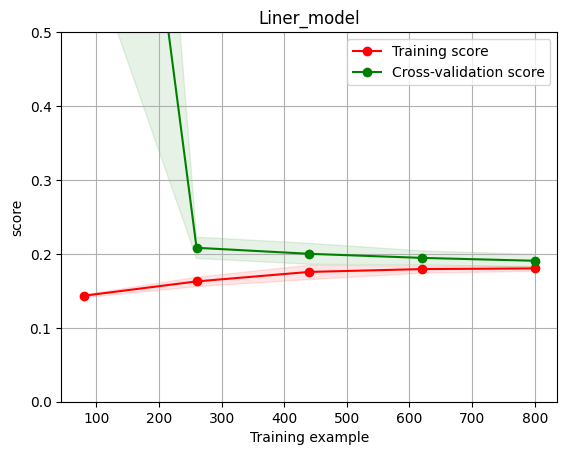

In [106]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

#### 4.3 multiple models

In [107]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [109]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [110]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


In [111]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


In [113]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:18.750748443085662


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

In [114]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.671710763793982


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

In [115]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:8.672182470075398


TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

#### 4.3 - 2 non-linear model

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [38]:
pip install xgboost lightgbm -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     -------------------------------------- 150.0/150.0 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 1.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [117]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [119]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 73383, number of used features: 33
[LightGBM] [Info] Start training from score 8.164231
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 73383, number of used features: 33
[LightGBM] [Info] Start training from score 8.168351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overh

In [46]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.200199,0.140837,0.168900,368.425973,0.140317,0.141542
cv2,0.193758,0.191904,0.142257,0.171831,324.132343,0.140923,0.145501
cv3,0.194132,0.189556,0.140941,0.170902,611.186880,0.139739,0.143887
cv4,0.191825,0.190797,0.140719,0.169056,765.200565,0.137492,0.142497
cv5,0.195758,0.202288,0.145952,0.174078,384.894216,0.143021,0.144852


#### 5.4.4 - 1 greedy parameter tuning

In [48]:

best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

<AxesSubplot:>

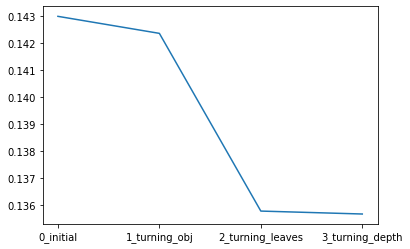

In [49]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

#### 4.4 - 2 Grid Search 

In [50]:
from sklearn.model_selection import GridSearchCV

In [51]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [52]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [53]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [54]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.1375498038741029

#### 4.4 - bayesian-optimization

In [57]:
!pip install bayesian-optimization

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.aliyun.com/pypi/simple
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11686 sha256=a27a2be2b1798da36c2b65c71f197c42482fc7b28b4885a12c750c5541a481a4
  Stored in directory: /home/admin/.cache/pip/wheels/25/8b/a6/182574d55dfb7c7ca276ffccbd05f36ec9336b08b7244b78e6
Successfully built bayesian-optimization


In [58]:
from bayes_opt import BayesianOptimization

In [59]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [60]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [ ]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8651   |  11.65    |  80.05    |  59.04    |  0.377    |
|  2        |  0.8518   |  59.61    |  12.86    |  20.51    |  0.9305   |
|  3        |  0.8596   |  55.92    |  76.14    |  36.86    |  0.5089   |
|  4        |  0.8612   |  68.22    |  70.43    |  41.69    |  0.6016   |
|  5        |  0.8682   |  89.33    |  68.71    |  87.44    |  0.9421   |
|  6        |  0.8253   |  3.867    |  97.03    |  98.98    |  0.5146   |
|  7        |  0.8507   |  5.633    |  4.214    |  93.7     |  0.1725   |
|  8        |  0.8681   |  88.36    |  71.62    |  85.06    |  0.7962   |
|  9        |  0.8688   |  99.38    |  3.327    |  92.97    |  0.1082   |
|  10       |  0.802    |  2.581    |  98.27    |  3.02     |  0.4331   |
|  11       |  0.8683   |  47.76    |  36.64    |  84.46    |  0.2095   |
|  12       |  0.8257   |  3.131    | 

In [ ]:
1 - rf_bo.max['target']

In [ ]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])